In [ ]:

import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import helper_functions as hf

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")
%matplotlib inline

df_blockchain = pd.read_csv("df_blockchain.csv", delimiter=",")
# get columns (You can add more columns to analyse results)
columns = ["market-price"]
dataset = df_blockchain[columns]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(columns)))
# split datatest into data_train, data_valid and data_test

data_train = dataset[:3000]
data_valid = dataset[3000:-30]
data_test = dataset[-30:]
rnn_size = 3
def process_data(data, rnn_size, target_id=0, columns_size=len(columns)):
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data[i:i+rnn_size,:])
        y.append(data[i+rnn_size,0])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)
    # process data for RNN
X_train, y_train = process_data(data_train,rnn_size)
X_val, y_val = process_data(data_valid,rnn_size)
X_test, y_test = process_data(data_test,rnn_size)
data_sets = [y_train, y_val, y_test]
for set in data_sets :
    set = set.reshape(len(set), 1)

# LSTM + Dense model

# Parameters

h1 = 50 # Size of LSTM layer
lambda2_list = np.logspace(-9,0,10)

# Build the models

model_names = ['lstm', 'stk_lstm', 'dd_lstm']
model_list = []

## LSTM model

i = 1
for lambda2 in lambda2_list : 
  print(i)
  lstm = keras.Sequential()
  lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2), return_sequences=True))
  lstm.add(layers.Dense(1, kernel_regularizer = regularizers.l2(lambda2), activation = 'relu'))
  model_list.append(lstm)
  i+=1

## Stacked-LSTM model

stk_lstm = keras.Sequential()
stk_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2), return_sequences=True, input_shape = (X_train.shape[1], 1)))
stk_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2), return_sequences=True))
stk_lstm.add(layers.Dense(1, kernel_regularizer = regularizers.l2(lambda2), activation = 'relu'))
model_list.append(stk_lstm)

# ## Double-dense-LSTM model

# dd_lstm = keras.Sequential()
# dd_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2)))
# dd_lstm.add(layers.Dense(10,kernel_regularizer = regularizers.l2(lambda2)))
# dd_lstm.add(layers.Dense(1, kernel_regularizer = regularizers.l2(lambda2), activation = 'relu'))
# model_list.append(stk_lstm)

# ## Attention-LSTM model

# att_lstm = keras.Sequential()
# att_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2)))
# att_lstm.add(layers.Attention())
# model_list.append(att_lstm)

1
2
3
4
5
6
7
8
9
10


In [ ]:
# Influence of regularization

rmse_train = []
rmse_test = []
N = 100
i = 1

for model in model_list:
    print(f'Fit with {i}-th value of lambda2')
    model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam())
    model.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_data = (X_val, y_val), verbose = 0)

    # RMSE for train
    y = model.predict(X_train)
    y_inverse = scaler.inverse_transform(np.concatenate([y.reshape(len(y),rnn_size), data_train[-len(y):,:]], axis=1))
    y_train_inverse = scaler.inverse_transform(data_train.reshape(-1,len(columns)))[rnn_size:]
    rmse = np.sqrt(np.mean((y_inverse - y_train_inverse)**2))
    rmse_train.append(rmse)

    # RMSE for test
    y_pred = lstm.predict(X_test)
    y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred.reshape(len(y_pred),rnn_size), data_test[-len(y_pred):,:]], axis=1))
    y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]
    rmse_score = np.sqrt(np.mean((y_pred_inverse - y_test_inverse)**2))
    rmse_test.append(rmse_score)

    i+=1

Fit with 1-th value of lambda2
Fit with 2-th value of lambda2
Fit with 3-th value of lambda2
Fit with 4-th value of lambda2
Fit with 5-th value of lambda2
Fit with 6-th value of lambda2
Fit with 7-th value of lambda2
Fit with 8-th value of lambda2
Fit with 9-th value of lambda2
Fit with 10-th value of lambda2


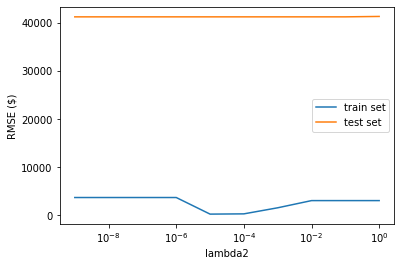

In [ ]:
lambda2_list
# plot the graph

rmse_train = np.array(rmse_train)
rmse_test = np.array(rmse_test)

plt.plot(lambda2_list, rmse_train, label='train set')
plt.plot(lambda2_list, rmse_test, label='test set')
plt.xlabel('lambda2')
plt.xscale('log')
plt.ylabel('RMSE ($)')
plt.legend()
plt.show()